# Predicting Heart disease

Use Machine learning models to predict risk of heart disease based on several medical attributes.
Dataset is the UCI heart disease [dataset](https://archive.ics.uci.edu/dataset/45/heart+disease). 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, f1_score



In [8]:
heart_disease_df = pd.read_csv("heart-disease.csv")
heart_disease_df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


## Exploratory DA

In [11]:
print(heart_disease_df.shape)
print(heart_disease_df["target"].value_counts())

(303, 14)
target
1    165
0    138
Name: count, dtype: int64


<Axes: xlabel='target'>

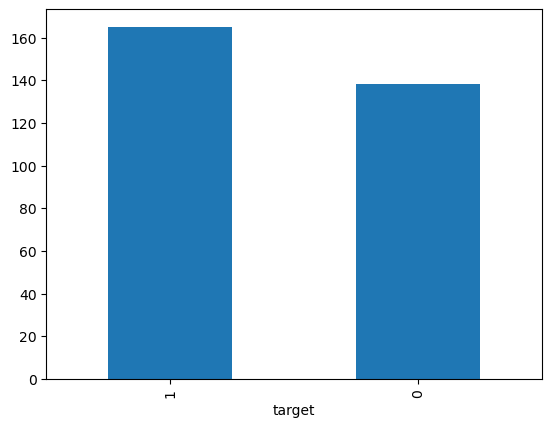

In [13]:
heart_disease_df.target.value_counts().plot(kind = "bar")

In [16]:
## missing values? 
print(heart_disease_df.isna().sum())

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64


In [17]:
heart_disease_df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


([<matplotlib.axis.XTick at 0x243ce15d290>,
 [Text(0, 0, 'No heart disease'), Text(1, 0, 'heart disease')])

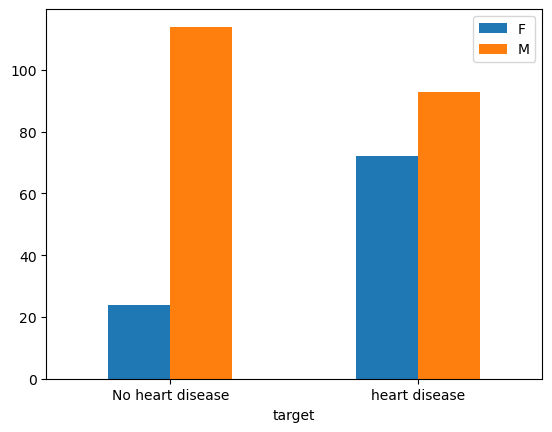

In [27]:
# 0 = female, 1 = male
pd.crosstab(heart_disease_df.target, heart_disease_df.sex)
pd.crosstab(heart_disease_df.target, heart_disease_df.sex).plot(kind = "bar")
plt.legend(["F", "M"])
plt.xticks(ticks = [0,1], labels=["No heart disease", "heart disease"], rotation = 0)

It appears the majority of women in the dataset have heart disease. Almost 75%

Text(0, 0.5, 'Max Heart Rate')

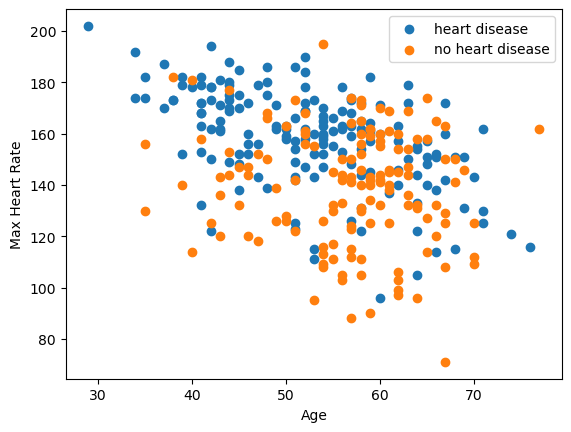

In [34]:
# age and heart rate
# thalach = maximum heart rate fo patient. 

# compare positive examples with negative examples
plt.scatter(heart_disease_df.age[heart_disease_df.target == 1], heart_disease_df.thalach[heart_disease_df.target == 1])
plt.scatter(heart_disease_df.age[heart_disease_df.target == 0], heart_disease_df.thalach[heart_disease_df.target == 0])
plt.legend(["heart disease", "no heart disease"])
plt.xlabel("Age")
plt.ylabel("Max Heart Rate")

<Axes: ylabel='Frequency'>

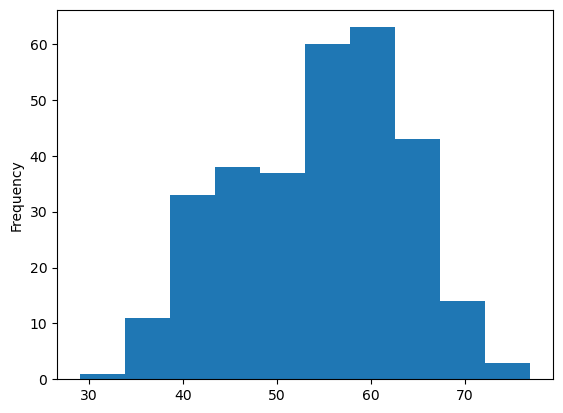

In [35]:
# what is the age distribution? 

heart_disease_df.age.plot.hist()

Age distribution is relatively normal, with some skew over older people. 

([<matplotlib.axis.XTick at 0x243cf877cd0>,
 [Text(0, 0, 'typical angina'),
  Text(1, 0, 'atypical angina'),
  Text(2, 0, 'non-anginal pain'),
  Text(3, 0, 'asymptomatic')])

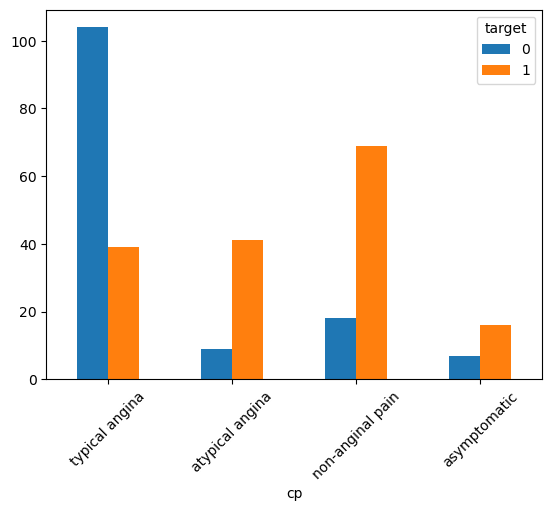

In [41]:
# Chest pain 
# cp: chest pain type
#         -- Value 1: typical angina
#         -- Value 2: atypical angina
#         -- Value 3: non-anginal pain
#         -- Value 4: asymptomatic


pd.crosstab(heart_disease_df.cp, heart_disease_df.target).plot(kind = "bar")
plt.xticks(ticks = [0,1,2,3], 
           labels = ["typical angina", "atypical angina", "non-anginal pain", "asymptomatic"],
           rotation = 45)


In [43]:
# build correlation matrix between independent and dependent variables. 

heart_disease_df.corr()["target"]

age        -0.225439
sex        -0.280937
cp          0.433798
trestbps   -0.144931
chol       -0.085239
fbs        -0.028046
restecg     0.137230
thalach     0.421741
exang      -0.436757
oldpeak    -0.430696
slope       0.345877
ca         -0.391724
thal       -0.344029
target      1.000000
Name: target, dtype: float64

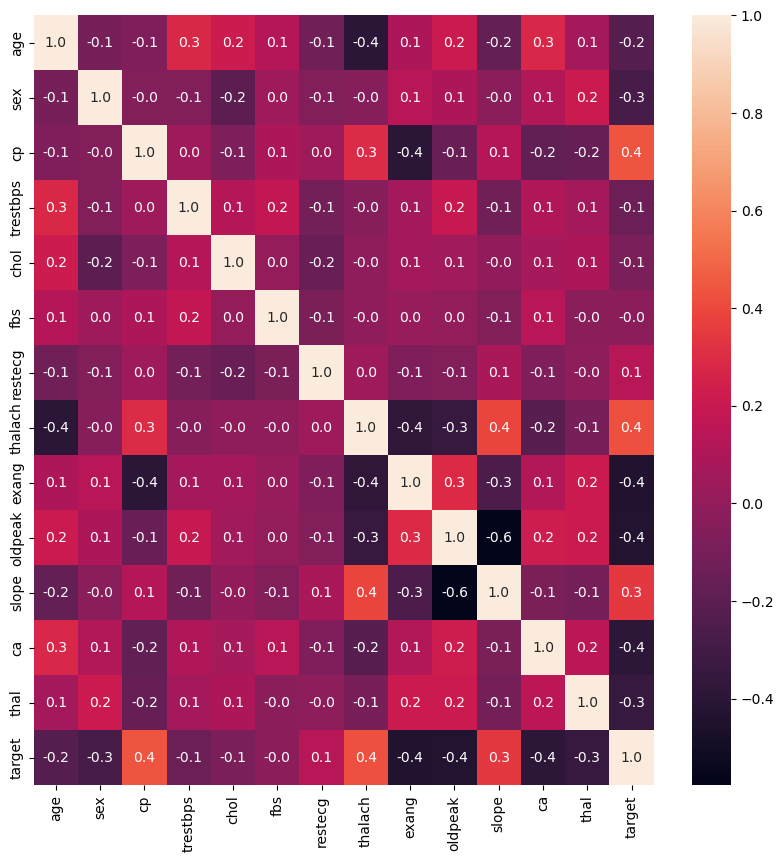

In [51]:
from seaborn import heatmap

corr_matrix = heart_disease_df.corr()
fig, _ = plt.subplots(figsize = (10,10))
ax = heatmap(corr_matrix, 
             annot=True, 
             fmt = ".1f")